# Image Classification

In [1]:
from fastai.vision.all import *
import re

## From Dogs and Cats to Pet Breeds

For the PETS dataset, we can use regular expressions to parse each image name for a dog breed and return a label for that image.

Get pet images and set the base path to location of images:

In [2]:
path = untar_data(URLs.PETS)
Path.BASE_PATH = path;
path.ls()

(#2) [Path('annotations'),Path('images')]

List files in *images* directory:

In [3]:
(path/'images').ls()

(#7393) [Path('images/american_pit_bull_terrier_4.jpg'),Path('images/scottish_terrier_198.jpg'),Path('images/Russian_Blue_106.jpg'),Path('images/chihuahua_151.jpg'),Path('images/american_bulldog_35.jpg'),Path('images/chihuahua_137.jpg'),Path('images/english_setter_98.jpg'),Path('images/american_bulldog_132.jpg'),Path('images/japanese_chin_133.jpg'),Path('images/boxer_112.jpg')...]

Get path of first image as a string:

In [4]:
fname = (path/"images").ls()[0]

Test regex expression to get image name:

In [5]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['american_pit_bull_terrier']

Use DataBlock class to label image files. Label each image by the breed as specified in the image name. Presize all images using `item_tfms=Resize(460)` and `batch_tfms=aug_transforms(size=224, min_scale=0.75)`.

In [6]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

Presizing consists of two steps:

1. Resize (crop) an image to dimensions larger than we would use for training.
2. Combine all data augmentations into one, and interpolate it at the end.

Step 1 prevents the generation of empty zones after image transformations. Step 2 prevents destruction of data within the images (since performing operations in sequence and interpolating after each one could lose lots of data).

### Checking and Debugging a DataBlock

It is good practice to check the images we are working with to verify they are accurate. We can additionally use the `summary` method to get verbose output on what goes on behind the scenes when constructing a batch and transforming the images.

Show 3 images from a batch. Use Google to verify that the labels match the dog shown in the image before we begin training.

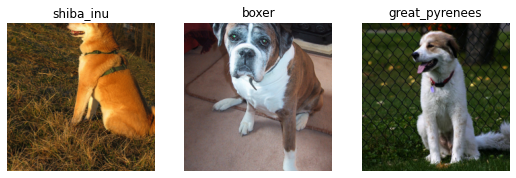

In [7]:
dls.show_batch(nrows=1, ncols=3)

Train a CNN over two epochs.

In [8]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.630774,0.408586,0.128552,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.582884,0.334385,0.107578,01:00
1,0.378612,0.264082,0.091340,00:59


## Cross-Entropy Loss

### Viewing Activations and Labels

If we look at the activations for each image in a batch, we can see that there is an activation that corresponds to each category. In order to make our activations useful, they need to be positive and sum to 1.

Get a batch from our `DataLoader`. Save the images into `x` and the corresponding labels into `y`.

In [9]:
x,y = dls.one_batch()

Show the index of the label that each image was given:

In [10]:
y

TensorCategory([ 0, 27, 34,  2,  5, 13, 12, 11, 30,  6, 16,  8,  7, 15,  8, 18, 36, 36,
         3,  4, 21, 27, 30, 25, 28, 13, 25, 20, 24,  9, 24,  1, 25, 22, 13, 27,
        13, 10, 26, 13, 30,  9, 12, 31, 11, 27,  3, 19, 33, 20,  0, 20, 21, 27,
         2, 14, 25, 12, 10, 22,  9,  5, 21, 10], device='cuda:0')

Get the activations for our model by passing our `x` and `y` into `get_preds()`.
`preds[0]` gets the activations for the first image in our batch. The numbers below represent the "confidence" in each label that our model classifies our image as.

In [11]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([9.9174e-01, 2.1045e-03, 1.0954e-07, 1.0878e-04, 4.4431e-04, 1.2346e-03,
        7.7751e-05, 5.5113e-07, 6.4235e-05, 3.6704e-03, 4.8239e-04, 3.4179e-05,
        1.1730e-07, 1.0464e-06, 1.3216e-06, 6.6914e-07, 5.8304e-06, 1.6727e-06,
        6.2363e-08, 1.9427e-06, 2.3867e-06, 3.3858e-07, 2.5374e-08, 7.4811e-07,
        1.3343e-07, 2.1028e-06, 6.8901e-06, 2.0285e-07, 2.9642e-06, 2.7197e-06,
        2.0868e-07, 3.2709e-07, 1.3390e-07, 3.1752e-06, 1.1832e-07, 1.0868e-06,
        2.0130e-06])

`len(preds[0])`: there are 37 possible labels, so there are 37 activations per image.

`preds[0].sum()`: the activations for each image add up to 1, since they are the current likelihoods at our image is a certain type of category.

In [12]:
len(preds[0]), preds[0].sum()

(37, tensor(1.0000))

### Softmax

The softmax activation function is a powerful way to calculate activations such that they are positive and sum to 1. It is similar to the sigmoid function, but it ensures the sum of activations for each image equals 1. It also works well when multiple categories are in play, and because of this, it is involved in the first part of finding cross-entropy loss.

Simulate activations for 6 images and 2 categories. The tensor below contains random numbers with a standard deviation of 2.

In [13]:
acts = torch.randn((6,2)) * 2
acts

tensor([[-1.1590,  0.4517],
        [ 2.2823,  0.2790],
        [-2.9664,  0.5550],
        [-0.7854,  1.0817],
        [-1.3176,  0.3735],
        [ 2.9759,  0.3029]])

Passing the activations through sigmoid shows why we don't use sigmoid to evaluate our activations, since they do not sum to 1.

In [14]:
acts.sigmoid()

tensor([[0.2389, 0.6110],
        [0.9074, 0.5693],
        [0.0490, 0.6353],
        [0.3132, 0.7468],
        [0.2112, 0.5923],
        [0.9515, 0.5752]])

We can take the difference between the two activations per image and find out how much greater the more confident category is. If we take the sigmoid of this, we get a reasonable activation less than 1.

In [15]:
(acts[:,0] - acts[:,1]).sigmoid()

tensor([0.1665, 0.8811, 0.0287, 0.1339, 0.1556, 0.9354])

Below, we can see we get the same results when we pass the activations through `softmax`. The first number is our confidence that the image is the first category, and the second number is our confidence that the image is the second category.

In [16]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.1665, 0.8335],
        [0.8811, 0.1189],
        [0.0287, 0.9713],
        [0.1339, 0.8661],
        [0.1556, 0.8444],
        [0.9354, 0.0646]])

### Log Likelihood

This section explores different ways to select the confidences after they have been put through softmax.

Below, we simulate a binary classifier:

In [17]:
targ = tensor([0,1,0,1,1,0])  # labels
sm_acts                       # activations

tensor([[0.1665, 0.8335],
        [0.8811, 0.1189],
        [0.0287, 0.9713],
        [0.1339, 0.8661],
        [0.1556, 0.8444],
        [0.9354, 0.0646]])

Use tensor indexing to select the loss from the column in `sm_acts` containing the correct label in `targ`:

In [18]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.1665, 0.1189, 0.0287, 0.8661, 0.8444, 0.9354])

Below, we compare how `F.nll_loss` selects the proper loss from `sm_acts` as well, except that it makes them negative.

In [19]:
-sm_acts[idx, targ], F.nll_loss(sm_acts, targ, reduction='none')

(tensor([-0.1665, -0.1189, -0.0287, -0.8661, -0.8444, -0.9354]),
 tensor([-0.1665, -0.1189, -0.0287, -0.8661, -0.8444, -0.9354]))

### Taking the Log

This section puts together taking the softmax and then the log likelihood to calculate the *cross-entropy* loss. It discusses the importance of logarithmic functions in neural networks, since it allows for the computation of very, very small or very, very large inputs.

Taking the positive or negative log of our probabilities returns the *negative log likelihood* loss.

We can calculate cross-entropy loss by first taking the softmax of our activations, and then taking the log likelihood of that. Or, we can use the PyTorch function `nn.CrossEntropyLoss` or `F.cross_entropy`. Both of these calculate the mean of the losses.

In [20]:
loss_func2 = nn.CrossEntropyLoss()
loss_func2(acts, targ), F.cross_entropy(acts, targ)

(tensor(1.3088), tensor(1.3088))

Set the parameter `reduction` to `none` if you do not want PyTorch loss functions to take the mean of the losses.

In [21]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([1.7928, 2.1298, 3.5506, 0.1437, 0.1692, 0.0668])

## Model Interpretation

Loss functions are hard to interpret (as they're used by the computer), so we as humans evaluate our models through metrics.

Plotting the confusion matrix from our learner above, we get:

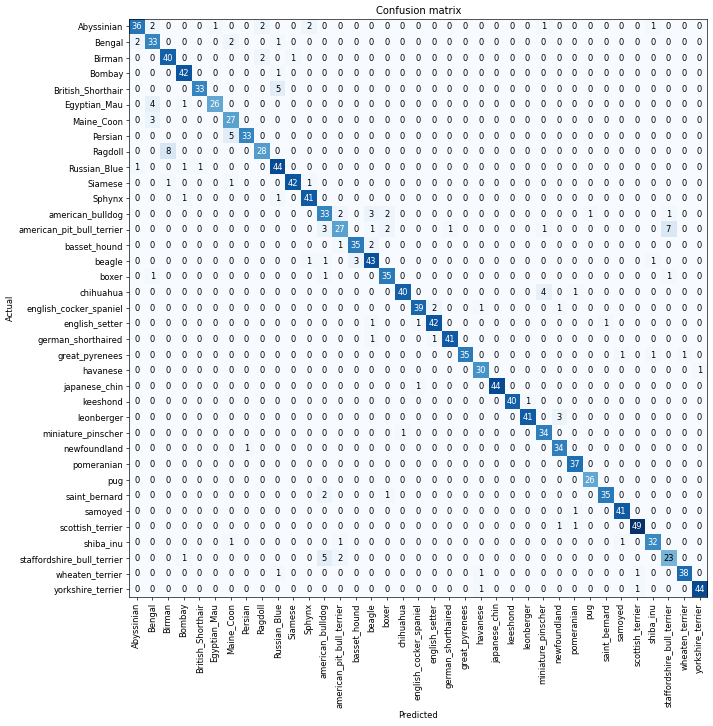

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

To more easily find the cells of the confusion matrix with the most incorrect predictions, we can use the `most_confused` method.

In [23]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 8),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('Persian', 'Maine_Coon', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5)]

## Improving Our Model

### The Learning Rate Finder

We need to pick a learning rate to be just right in order for our model to train as efficiently as possible.

Making the learning rate very high leads to a very high error rate.

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.550753,5.075166,0.464817,00:48


epoch,train_loss,valid_loss,error_rate,time
0,2.852624,1.313323,0.412043,01:00


When we plot our losses over the learning rate, we see even more clearly how picking a good learning rate can help with training our model. Below, we can see that nothing really happens to the loss from 1e-6 to 1e-3. So, we don't want to choose a learning rate in that range. 

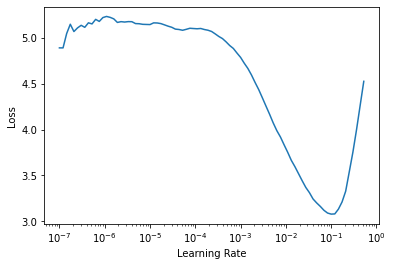

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

The steepest point of the plot is around 3e-3, so we can have that as our learning rate.

In [26]:
print(f"Minimum/10: {lr_min:.2e}, steepest_point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest_point: 4.37e-03


Using the learning rate we chose above:

In [27]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.372586,0.426380,0.133288,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.562900,0.371256,0.117727,01:00
1,0.375854,0.257026,0.080514,01:00


### Unfreezing and Transfer Learning

Let's look up the information on the `fine_tune` method:

In [28]:
learn.fine_tune??

# TODO: study this more carefully!

In [29]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.209789,0.387831,0.126522,00:48
1,0.615520,0.322701,0.107578,00:48
2,0.385637,0.260368,0.092693,00:49


In [30]:
learn.unfreeze()

We need to calculate a new learning rate (like in the *learning rate finder* algorithm) in order to improve our model (so our rate is not too high and not too low).

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=7.585775847473997e-07)

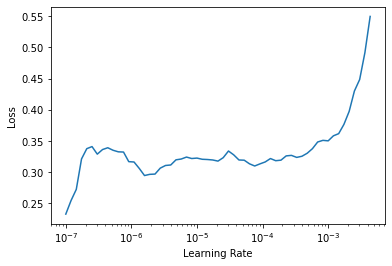

In [31]:
learn.lr_find()

Pick a new learning rate to use. Here, we use 1e-5, since it is far enough from the steep incline where it won't reach it (we don't want the steep incline).

In [32]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.314172,0.257711,0.086604,01:00
1,0.304658,0.250143,0.087957,01:00
2,0.284912,0.244664,0.083221,01:00
3,0.263234,0.236439,0.079161,01:00
4,0.264605,0.235791,0.079838,01:00
5,0.257946,0.236290,0.076455,01:00


### Discriminative Learning Rates

We pass in a `slice` object, with the first value (1e-6) being the learning rate in the earliest layer of the neural network and the second value (1e-4) being the learning rate in the final layer. This training will start with a very low learning rate, and work its way up to a learning rate that is "just right."

In [33]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.221200,0.411902,0.127199,00:48
1,0.596921,0.291406,0.093369,00:49
2,0.382433,0.271911,0.092693,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.322871,0.264300,0.089310,01:00
1,0.299322,0.249992,0.081191,01:00
2,0.291409,0.248997,0.081191,01:00
3,0.278598,0.242978,0.083221,01:00
4,0.253044,0.233004,0.073748,01:00
5,0.240946,0.233585,0.072395,01:00
6,0.223562,0.230627,0.073748,01:00
7,0.201574,0.228037,0.072395,01:00
8,0.198041,0.226416,0.076455,01:00
9,0.203997,0.227410,0.074425,01:00


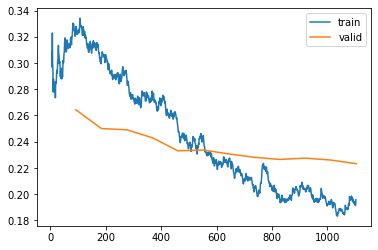

In [34]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

Choosing the right number of epochs (or the right amount of time to train) is important for your model's metrics after training has finished. Sometimes, your model's metrics will keep improving even in the final epochs of training. Sometimes, those metrics may get worse in the later stages as the model overfits.

### Deeper Architectures

Pretrained architectures like ResNet have some variants that use more layers. Deeper models have the capacity to process more parameters and underlying trends, but at the same time are more prone to overfitting (since they memorize specifics a lot better). Deeper models also require more GPU RAM and take more time to train.

It is not always beneficial to train a deep model because of this; always start with a small one before scaling up (if needed).

## Conclusion

Cross-entropy loss is incredibly important, as it (or at least a variant of it) is used in nearly every classification model.

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.